# Employment by sector and departement

In [1]:
from pynsee.localdata import *
from pynsee.geodata import *
from pynsee.metadata import *
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!


In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
dep = dep.translate()
dep = dep.zoom()
dep = dep[["insee_dep", "geometry"]]
# remove overseas departments
# dep = dep[~dep['insee_dep'].isin(['971', '972', '973', '974', '976'])]
dep = dep.rename(columns={'insee_dep': 'CODEGEO'})
dep

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/i

,CODEGEO,geometry
0,971,(POLYGON ((-739144.7682380155 6296095.81074990...
1,972,(POLYGON ((-756752.3867035061 6056818.79477141...
2,974,(POLYGON ((-807378.5642103208 5867965.28138863...
3,973,(POLYGON ((-803842.1357295588 5783486.39767461...
4,976,"(POLYGON ((-553726.6242966857 5453062.7250621,..."
...,...,...
100,95,"(POLYGON ((271116.09678243 6297637.40344712, 2..."
0,75,(POLYGON ((-368512.6344774401 6565058.19578084...
1,92,(POLYGON ((-384521.0612397401 6582694.80930822...
2,93,(POLYGON ((-357905.63639453007 6588530.5301145...


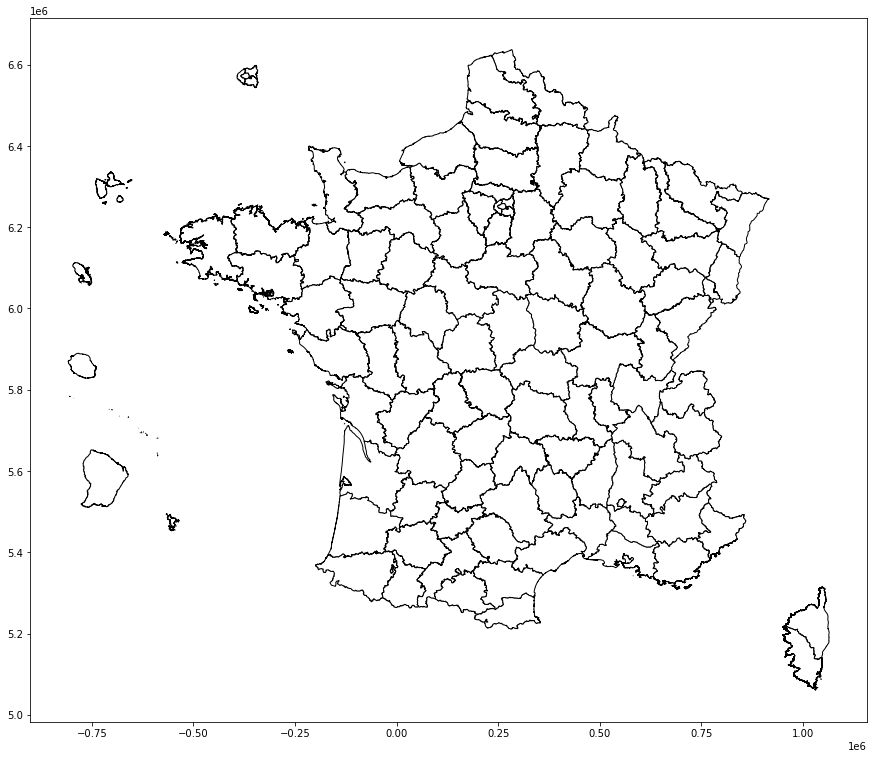

In [3]:
dep2 = gpd.GeoDataFrame(dep)
ax = dep2.plot(color='white', edgecolor='black', figsize = (15,15))
plt.show()

In [4]:
# get local data from INSEE API
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Locally saved data has been used
Set update=True to trigger an update
By default, the query is on all departements
Locally saved data has been used
Set update=True to trigger an update


In [5]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [6]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [7]:
# merge values and geographic limits
datamap = df.merge(dep, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap)

In [8]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

In [9]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt

datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique() 

In [10]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(datamap['TITLE_A17_EN']).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"])
datamap

,CODEGEO,NIVGEO,UNIT,UNIT_label_fr,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,GEO_DATE,CODEGEO_label,employment_share,geometry,A5,A10,TITLE_A17_EN,TITLE_A17_FR,center
184,92,DEP,NBSALET,Postes salariés dans les établissements,OQ,193252.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Hauts-de-Seine,17.574866,"MULTIPOLYGON (((-384521.061 6582694.809, -3840...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-381663.3857752473 6570339.729166886)
1494,15,DEP,NBSALET,Postes salariés dans les établissements,OQ,19902.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Cantal,43.825421,"MULTIPOLYGON (((234011.357 5631328.379, 234095...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (297132.1847237096 5629739.68843575)
1120,40,DEP,NBSALET,Postes salariés dans les établissements,OQ,41579.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Landes,34.439944,"MULTIPOLYGON (((-150466.072 5465682.645, -1504...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-87229.51844599277 5460398.995074544)
525,14,DEP,NBSALET,Postes salariés dans les établissements,OQ,90141.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Calvados,35.919618,"MULTIPOLYGON (((-47856.437 6251825.615, -47735...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-40231.4420775164 6291926.870039062)
1647,04,DEP,NBSALET,Postes salariés dans les établissements,OQ,19565.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Alpes-de-Haute-Provence,40.993568,"MULTIPOLYGON (((626874.471 5488749.945, 627113...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (695212.592539985 5482087.622821789)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,31,DEP,NBSALET,Postes salariés dans les établissements,C2,26.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Haute-Garonne,0.004384,"MULTIPOLYGON (((117041.418 5415884.623, 117066...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (130916.08019596638 5367032.990126808)
495,90,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Territoire de Belfort,0.000000,"MULTIPOLYGON (((755903.679 6048474.372, 755844...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (771284.3142524358 6045847.551103318)
342,41,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Loir-et-Cher,0.000000,"MULTIPOLYGON (((93147.979 6108318.685, 93085.6...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (158851.70250157852 6043580.709749965)
1719,83,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Var,0.000000,"MULTIPOLYGON (((696715.041 5311473.208, 696709...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (695161.7441772111 5379580.598117414)


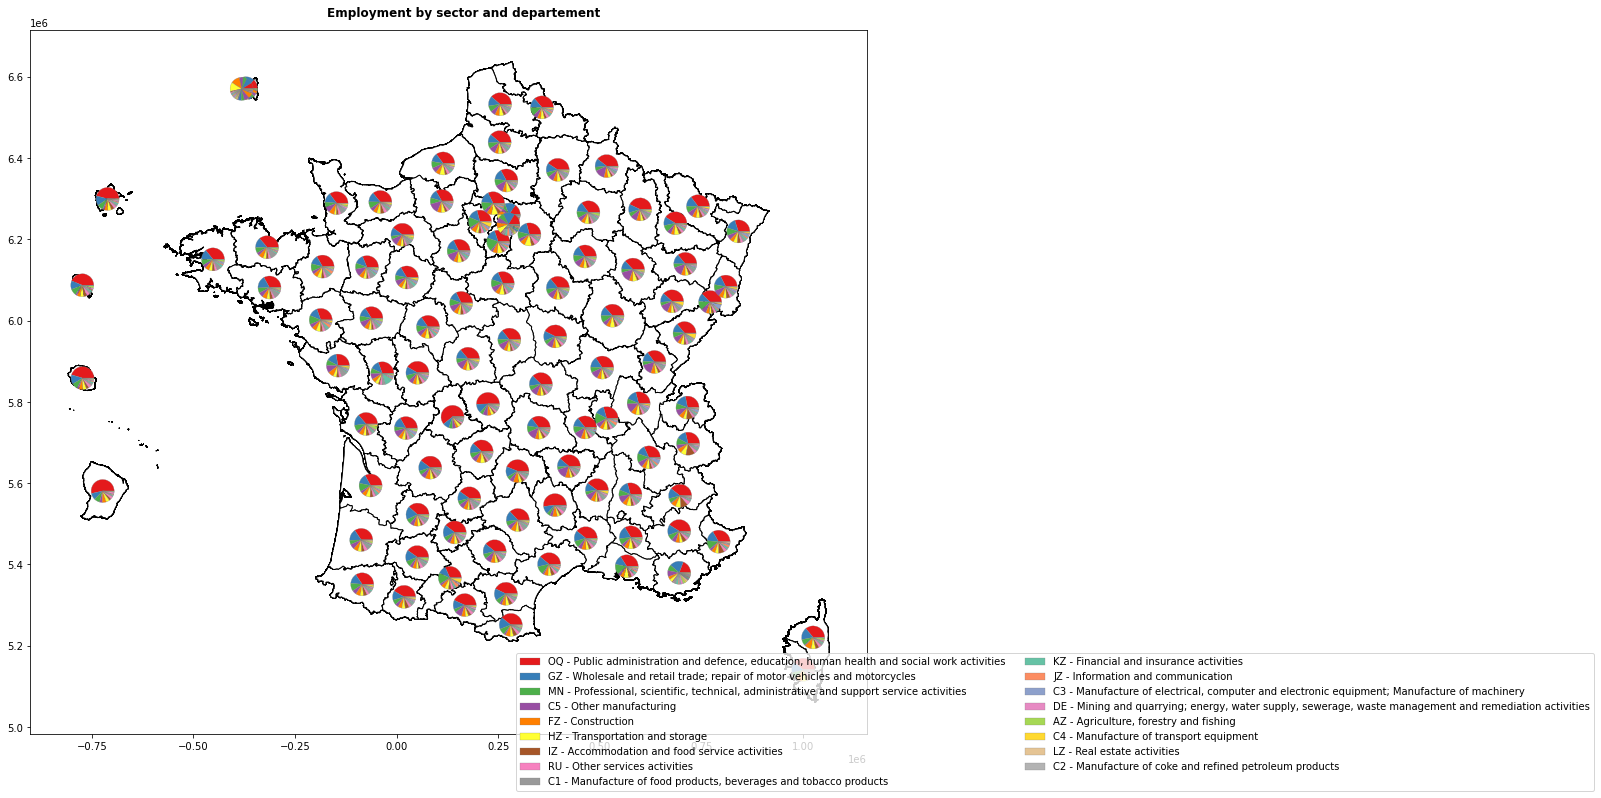

In [11]:
# draw plot

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

for idep in list_dep:
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    ratios = df["employment_share"]
    Y, X = wkt.loads(df.loc[0, "center"]).xy
    ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=(Y[0], X[0]), bbox_transform=ax.transData)
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
    
plt.suptitle('Employment by sector and departement', x = 0.4, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.legend(emplTot.index, loc="lower left", bbox_to_anchor=(-10, -5), ncol=2)

plt.show()